In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import GroupKFold

from nyaggle.experiment import run_experiment

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 500)

In [2]:
train_df = pd.read_parquet('../data/feature_engineering_v3_train_df.parquet')
test_df = pd.read_parquet('../data/feature_engineering_v3_test_df.parquet')

In [2]:
train_label = pd.read_csv('../train_label.csv')
train_log = pd.read_csv('../train_log.csv')
test_session = pd.read_csv('../test_session.csv')
test_log = pd.read_csv('../test_log.csv')

In [7]:
"""
# MultiuHotEncodingはメモリが足りない
from sklearn.preprocessing import MultiLabelBinarizer
# session_idごとにyad_noのリストを作成
session_yadno = train_log.groupby('session_id')['yad_no'].apply(list)
# MultiLabelBinarizerのインスタンスを作成
mlb = MultiLabelBinarizer()
# MultiHotEncodingを実施
multi_hot_encoded = mlb.fit_transform(session_yadno)
# 結果をDataFrameに変換
multi_hot_df = pd.DataFrame(multi_hot_encoded, columns=mlb.classes_, index=session_yadno.index)
# 結果の最初の数行を表示
multi_hot_df.head()
"""

,2,3,4,5,6,7,9,10,11,12,...,13796,13797,13798,13799,13800,13801,13803,13804,13805,13806
session_id,,,,,,,,,,,,,,,,,,,,,
000007603d533d30453cc45d0f3d119f,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0000ca043ed437a1472c9d1d154eb49b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0000d4835cf113316fe447e2f80ba1c8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0000fcda1ae1b2f431e55a7075d1f500,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000104bdffaaad1a1e0a9ebacf585f33,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# train_logとtest_logを結合
log_df = pd.concat([train_log, test_log], sort=False)

# session_idごとにyad_noのリストを作成
session_yadno = log_df.groupby('session_id')['yad_no'].apply(list)
# session_yadnoがシリーズであるため、これをデータフレームに変換
session_yadno_df = session_yadno.reset_index(name='yadno_list')
session_yadno_df

,session_id,yadno_list
0,000007603d533d30453cc45d0f3d119f,[2395]
1,00001149e9c73985425197104712478c,"[3560, 1959]"
2,0000ca043ed437a1472c9d1d154eb49b,[13535]
3,0000d4835cf113316fe447e2f80ba1c8,[123]
4,0000e02747d749a52b7736dfa751e258,[11984]
...,...,...
463393,ffff9a7dcc892875c7a8b821fa436228,[8989]
463394,ffffb1d30300fe17f661941fd085b04b,[6030]
463395,ffffcd5bc19d62cad5a3815c87818d83,"[12230, 10619, 12230]"
463396,ffffe984aafd6127ce8e43e3ca40c79d,[8250]


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# yadno_listの各要素を文字列に変換
session_yadno_df['yadno_list_str'] = session_yadno_df['yadno_list'].apply(lambda x: ' '.join(map(str, x)))
# TF-IDFベクトルライザーの初期化
tfidf_vectorizer = TfidfVectorizer()
# yadno_list_str列にTF-IDF適用
tfidf_matrix = tfidf_vectorizer.fit_transform(session_yadno_df['yadno_list_str'])

# SVDの初期化（n次元に圧縮）
svd = TruncatedSVD(n_components=10, random_state=42)
# TF-IDF行列にSVDを適用
svd_matrix = svd.fit_transform(tfidf_matrix)
# 結果をデータフレームに追加
df_svd = pd.DataFrame(svd_matrix, columns=['SVD1', 'SVD2', 'SVD3', 'SVD4', 'SVD5', 'SVD6', 'SVD7', 'SVD8', 'SVD9', 'SVD10'])

In [6]:
df_svd

,SVD1,SVD2,SVD3,SVD4,SVD5,SVD6,SVD7,SVD8,SVD9,SVD10
0,-6.464468e-11,2.891166e-10,-3.660427e-10,-2.273841e-09,4.557487e-10,-4.159502e-09,-3.617492e-09,-1.332808e-08,-4.444905e-09,1.270314e-09
1,-3.463664e-06,-1.040443e-05,1.113840e-05,5.396236e-05,-7.213977e-05,6.641739e-05,1.259168e-06,3.709087e-04,3.118973e-04,-4.967234e-04
2,-5.978436e-08,-1.443403e-07,-7.438706e-07,1.818955e-06,4.992685e-06,3.372739e-06,-1.433128e-05,-2.026924e-05,2.013090e-05,2.943140e-05
3,-7.211434e-10,-4.702856e-10,-5.611851e-09,8.650022e-09,-1.469572e-08,-2.666743e-08,-5.462524e-08,2.190826e-08,-4.270148e-08,-2.773235e-08
4,4.135288e-04,-6.844452e-06,2.621962e-03,2.017062e-04,-2.268762e-04,8.729391e-04,1.513901e-04,-9.936004e-06,-7.057449e-04,-3.924756e-04
...,...,...,...,...,...,...,...,...,...,...
463393,-1.712870e-06,-3.114490e-06,-2.240174e-05,4.503927e-04,5.232237e-04,6.334048e-05,2.631501e-05,-6.399591e-05,-6.301729e-05,-7.216633e-05
463394,-1.193886e-05,-1.372869e-05,-6.676418e-05,5.990706e-05,-1.412355e-04,-1.268508e-04,1.693622e-04,1.087538e-04,8.125785e-05,4.445083e-04
463395,2.983684e-08,1.918854e-06,-4.454749e-07,-1.956481e-05,1.003508e-05,9.055960e-06,8.319465e-05,-7.836168e-05,7.000658e-05,8.072539e-05
463396,1.218516e-05,-2.288626e-06,2.281290e-05,-7.400444e-05,6.028522e-05,1.106125e-04,-8.938183e-04,9.540216e-04,-9.736687e-05,-1.681874e-04


In [7]:
# df_svdをsession_yadno_dfに結合
session_yadno_df = pd.concat([session_yadno_df, df_svd], axis=1)
session_yadno_df

,session_id,yadno_list,yadno_list_str,SVD1,SVD2,SVD3,SVD4,SVD5,SVD6,SVD7,SVD8,SVD9,SVD10
0,000007603d533d30453cc45d0f3d119f,[2395],2395,-6.464468e-11,2.891166e-10,-3.660427e-10,-2.273841e-09,4.557487e-10,-4.159502e-09,-3.617492e-09,-1.332808e-08,-4.444905e-09,1.270314e-09
1,00001149e9c73985425197104712478c,"[3560, 1959]",3560 1959,-3.463664e-06,-1.040443e-05,1.113840e-05,5.396236e-05,-7.213977e-05,6.641739e-05,1.259168e-06,3.709087e-04,3.118973e-04,-4.967234e-04
2,0000ca043ed437a1472c9d1d154eb49b,[13535],13535,-5.978436e-08,-1.443403e-07,-7.438706e-07,1.818955e-06,4.992685e-06,3.372739e-06,-1.433128e-05,-2.026924e-05,2.013090e-05,2.943140e-05
3,0000d4835cf113316fe447e2f80ba1c8,[123],123,-7.211434e-10,-4.702856e-10,-5.611851e-09,8.650022e-09,-1.469572e-08,-2.666743e-08,-5.462524e-08,2.190826e-08,-4.270148e-08,-2.773235e-08
4,0000e02747d749a52b7736dfa751e258,[11984],11984,4.135288e-04,-6.844452e-06,2.621962e-03,2.017062e-04,-2.268762e-04,8.729391e-04,1.513901e-04,-9.936004e-06,-7.057449e-04,-3.924756e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
463393,ffff9a7dcc892875c7a8b821fa436228,[8989],8989,-1.712870e-06,-3.114490e-06,-2.240174e-05,4.503927e-04,5.232237e-04,6.334048e-05,2.631501e-05,-6.399591e-05,-6.301729e-05,-7.216633e-05
463394,ffffb1d30300fe17f661941fd085b04b,[6030],6030,-1.193886e-05,-1.372869e-05,-6.676418e-05,5.990706e-05,-1.412355e-04,-1.268508e-04,1.693622e-04,1.087538e-04,8.125785e-05,4.445083e-04
463395,ffffcd5bc19d62cad5a3815c87818d83,"[12230, 10619, 12230]",12230 10619 12230,2.983684e-08,1.918854e-06,-4.454749e-07,-1.956481e-05,1.003508e-05,9.055960e-06,8.319465e-05,-7.836168e-05,7.000658e-05,8.072539e-05
463396,ffffe984aafd6127ce8e43e3ca40c79d,[8250],8250,1.218516e-05,-2.288626e-06,2.281290e-05,-7.400444e-05,6.028522e-05,1.106125e-04,-8.938183e-04,9.540216e-04,-9.736687e-05,-1.681874e-04


In [8]:
session_yadno_df[session_yadno_df['session_id'] == '000104bdffaaad1a1e0a9ebacf585f33']

,session_id,yadno_list,yadno_list_str,SVD1,SVD2,SVD3,SVD4,SVD5,SVD6,SVD7,SVD8,SVD9,SVD10
7,000104bdffaaad1a1e0a9ebacf585f33,"[96, 898]",96 898,-0.000002,-0.000001,-0.000017,0.000024,0.000003,0.000024,0.000023,-0.000042,-0.000092,-0.000071


In [9]:
session_yadno_df["SVD1"].value_counts().nunique()  

179

In [10]:
train_df = pd.merge(train_df, session_yadno_df[['session_id', 'SVD1', 'SVD2', 'SVD3', 'SVD4', 'SVD5', 'SVD6', 'SVD7', 'SVD8', 'SVD9', 'SVD10']], on='session_id', how='left')
test_df = pd.merge(test_df, session_yadno_df[['session_id', 'SVD1', 'SVD2', 'SVD3', 'SVD4', 'SVD5', 'SVD6', 'SVD7', 'SVD8', 'SVD9', 'SVD10']], on='session_id', how='left')

In [11]:
del session_yadno_df, df_svd

In [12]:
train_df.head()

,session_id,yado_no,target,seq_no,seen_yad,max_seq_no,diff_seq_no,is_odd,multiple_visits_flag,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd,popularity,overall_rank,wid_cd_rank,ken_cd_rank,lrg_cd_rank,sml_cd_rank,label_wid_cd,label_ken_cd,label_lrg_cd,label_sml_cd,count_wid_cd,count_ken_cd,count_lrg_cd,count_sml_cd,count_yado_no,fold,TE_wid_cd,TE_ken_cd,TE_lrg_cd,TE_sml_cd,TE_yado_no,SVD1,SVD2,SVD3,SVD4,SVD5,SVD6,SVD7,SVD8,SVD9,SVD10
0,000104bdffaaad1a1e0a9ebacf585f33,96,1,0,1,1,1,0,0,0,228.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,150.0,845.5,113.0,10.0,6.0,6.0,5,17,27,31,1725156,136135,52732,51851,1379,0,0.016339,0.025044,0.026324,0.025747,0.025022,-0.000002,-0.000001,-0.000017,0.000024,0.000003,0.000024,0.000023,-0.000042,-0.000092,-0.000071
1,000104bdffaaad1a1e0a9ebacf585f33,902,0,-1,0,1,-1,-1,0,0,240.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,154.0,785.5,103.0,9.0,5.0,5.0,5,17,27,31,1725156,136135,52732,51851,1336,0,0.016339,0.025044,0.026324,0.025747,0.039778,-0.000002,-0.000001,-0.000017,0.000024,0.000003,0.000024,0.000023,-0.000042,-0.000092,-0.000071
2,000104bdffaaad1a1e0a9ebacf585f33,12491,0,-1,0,1,-1,-1,0,0,144.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,179.0,547.5,58.0,5.0,2.0,2.0,5,17,27,31,1725156,136135,52732,51851,1339,0,0.016339,0.025044,0.026324,0.025747,0.047794,-0.000002,-0.000001,-0.000017,0.000024,0.000003,0.000024,0.000023,-0.000042,-0.000092,-0.000071
3,000104bdffaaad1a1e0a9ebacf585f33,5490,0,-1,0,1,-1,-1,0,0,116.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,143.0,945.0,126.0,13.0,9.0,9.0,5,17,27,31,1725156,136135,52732,51851,1349,0,0.016339,0.025044,0.026324,0.025747,0.040073,-0.000002,-0.000001,-0.000017,0.000024,0.000003,0.000024,0.000023,-0.000042,-0.000092,-0.000071
4,000104bdffaaad1a1e0a9ebacf585f33,1284,0,-1,0,1,-1,-1,0,0,176.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,141.0,979.5,128.0,14.0,10.0,10.0,5,17,27,31,1725156,136135,52732,51851,1348,0,0.016339,0.025044,0.026324,0.025747,0.040073,-0.000002,-0.000001,-0.000017,0.000024,0.000003,0.000024,0.000023,-0.000042,-0.000092,-0.000071


In [ ]:
# TargetEncodingに分散を追加(あとで)


# sessionの中の順序関係を理解させないといけないから,　それに関する特徴量をリッチにする必要がある
# メモリが足りるのか？

# 人気順(overall_rank)からsession内の候補の中での順序を特徴量にしたいです。つまりsession_id内での順序を特徴量にしたいです。


# 各session内における最大との差分
# 各session内における

In [25]:
"""
# 各session内における平均、最大、最小、標準偏差

# カラムのリストを作成します（'session_id'と'target'は除外します）
cols_to_describe = [col for col in train_df.columns if col not in ['session_id', 'target', 'fold', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd']]
# `session_id`でグループ化し、各カラムの統計量を計算します
stats_df = train_df.groupby('session_id')[cols_to_describe].agg(['max', 'min', 'mean', 'std'])
# インデックスをリセットして、`session_id`がカラムになるようにします
stats_df = stats_df.reset_index()
# MultiIndexカラムを扱いやすい形にします
stats_df.columns = ['_'.join(col).strip() if col[1] else col[0] for col in stats_df.columns.values]
# 結合する前に、カラム名を確認します
print(stats_df.columns)
# 元のデータフレームに結合します
train_df = train_df.merge(stats_df, on='session_id', how='left')
"""


Index(['session_id', 'yado_no_max', 'yado_no_min', 'yado_no_mean',
       'yado_no_std', 'seq_no_max', 'seq_no_min', 'seq_no_mean', 'seq_no_std',
       'seen_yad_max',
       ...
       'SVD8_mean', 'SVD8_std', 'SVD9_max', 'SVD9_min', 'SVD9_mean',
       'SVD9_std', 'SVD10_max', 'SVD10_min', 'SVD10_mean', 'SVD10_std'],
      dtype='object', length=185)


In [14]:
# カラムのリストを作成します（'session_id'と'target'は除外します）
cols_to_describe = [col for col in train_df.columns if col not in ['session_id', 'target', 'fold', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd']]

# `session_id`でグループ化し、各カラムの統計量を計算します
stats_df = train_df.groupby('session_id')[cols_to_describe].agg(['max', 'min', 'mean', 'std']).reset_index()

# MultiIndexカラムを扱いやすい形にします
stats_df.columns = ['_'.join(col).strip() if col[1] else col[0] for col in stats_df.columns.values]

# 結合する前に、カラム名を確認します
print(stats_df.columns)

# 統計量を計算したデータフレームを元のデータフレームに結合します
train_df = train_df.merge(stats_df, on='session_id', how='left')

# 最大値との差分を計算する
for col in cols_to_describe:
    max_col_name = f'{col}_max'  # 最大値のカラム名
    train_df[f'{col}_diff_max'] = train_df[max_col_name] - train_df[col]


Index(['session_id', 'yado_no_max', 'yado_no_min', 'yado_no_mean',
       'yado_no_std', 'seq_no_max', 'seq_no_min', 'seq_no_mean', 'seq_no_std',
       'seen_yad_max',
       ...
       'SVD8_mean', 'SVD8_std', 'SVD9_max', 'SVD9_min', 'SVD9_mean',
       'SVD9_std', 'SVD10_max', 'SVD10_min', 'SVD10_mean', 'SVD10_std'],
      dtype='object', length=181)


In [15]:
train_df.head()

,session_id,yado_no,target,seq_no,seen_yad,max_seq_no,diff_seq_no,is_odd,multiple_visits_flag,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd,popularity,overall_rank,wid_cd_rank,ken_cd_rank,lrg_cd_rank,sml_cd_rank,label_wid_cd,label_ken_cd,label_lrg_cd,label_sml_cd,count_wid_cd,count_ken_cd,count_lrg_cd,count_sml_cd,count_yado_no,fold,TE_wid_cd,TE_ken_cd,TE_lrg_cd,TE_sml_cd,TE_yado_no,SVD1,SVD2,SVD3,SVD4,SVD5,SVD6,SVD7,SVD8,SVD9,SVD10,yado_no_max,yado_no_min,yado_no_mean,yado_no_std,seq_no_max,seq_no_min,seq_no_mean,seq_no_std,seen_yad_max,seen_yad_min,seen_yad_mean,seen_yad_std,max_seq_no_max,max_seq_no_min,max_seq_no_mean,max_seq_no_std,diff_seq_no_max,diff_seq_no_min,diff_seq_no_mean,diff_seq_no_std,is_odd_max,is_odd_min,is_odd_mean,is_odd_std,multiple_visits_flag_max,multiple_visits_flag_min,multiple_visits_flag_mean,multiple_visits_flag_std,yad_type_max,yad_type_min,yad_type_mean,yad_type_std,total_room_cnt_max,total_room_cnt_min,total_room_cnt_mean,total_room_cnt_std,wireless_lan_flg_max,wireless_lan_flg_min,wireless_lan_flg_mean,wireless_lan_flg_std,onsen_flg_max,onsen_flg_min,onsen_flg_mean,onsen_flg_std,kd_stn_5min_max,kd_stn_5min_min,kd_stn_5min_mean,kd_stn_5min_std,kd_bch_5min_max,kd_bch_5min_min,kd_bch_5min_mean,kd_bch_5min_std,kd_slp_5min_max,kd_slp_5min_min,kd_slp_5min_mean,kd_slp_5min_std,kd_conv_walk_5min_max,kd_conv_walk_5min_min,kd_conv_walk_5min_mean,kd_conv_walk_5min_std,popularity_max,popularity_min,popularity_mean,popularity_std,overall_rank_max,overall_rank_min,overall_rank_mean,overall_rank_std,wid_cd_rank_max,wid_cd_rank_min,wid_cd_rank_mean,wid_cd_rank_std,ken_cd_rank_max,ken_cd_rank_min,ken_cd_rank_mean,ken_cd_rank_std,lrg_cd_rank_max,lrg_cd_rank_min,lrg_cd_rank_mean,lrg_cd_rank_std,sml_cd_rank_max,sml_cd_rank_min,sml_cd_rank_mean,sml_cd_rank_std,label_wid_cd_max,label_wid_cd_min,label_wid_cd_mean,label_wid_cd_std,label_ken_cd_max,label_ken_cd_min,label_ken_cd_mean,label_ken_cd_std,label_lrg_cd_max,label_lrg_cd_min,label_lrg_cd_mean,label_lrg_cd_std,label_sml_cd_max,label_sml_cd_min,label_sml_cd_mean,label_sml_cd_std,count_wid_cd_max,count_wid_cd_min,count_wid_cd_mean,count_wid_cd_std,count_ken_cd_max,count_ken_cd_min,count_ken_cd_mean,count_ken_cd_std,count_lrg_cd_max,count_lrg_cd_min,count_lrg_cd_mean,count_lrg_cd_std,count_sml_cd_max,count_sml_cd_min,count_sml_cd_mean,count_sml_cd_std,count_yado_no_max,count_yado_no_min,count_yado_no_mean,count_yado_no_std,TE_wid_cd_max,TE_wid_cd_min,TE_wid_cd_mean,TE_wid_cd_std,TE_ken_cd_max,TE_ken_cd_min,TE_ken_cd_mean,TE_ken_cd_std,TE_lrg_cd_max,TE_lrg_cd_min,TE_lrg_cd_mean,TE_lrg_cd_std,TE_sml_cd_max,TE_sml_cd_min,TE_sml_cd_mean,TE_sml_cd_std,TE_yado_no_max,TE_yado_no_min,TE_yado_no_mean,TE_yado_no_std,SVD1_max,SVD1_min,SVD1_mean,SVD1_std,SVD2_max,SVD2_min,SVD2_mean,SVD2_std,SVD3_max,SVD3_min,SVD3_mean,SVD3_std,SVD4_max,SVD4_min,SVD4_mean,SVD4_std,SVD5_max,SVD5_min,SVD5_mean,SVD5_std,SVD6_max,SVD6_min,SVD6_mean,SVD6_std,SVD7_max,SVD7_min,SVD7_mean,SVD7_std,SVD8_max,SVD8_min,SVD8_mean,SVD8_std,SVD9_max,SVD9_min,SVD9_mean,SVD9_std,SVD10_max,SVD10_min,SVD10_mean,SVD10_std,yado_no_diff_max,seq_no_diff_max,seen_yad_diff_max,max_seq_no_diff_max,diff_seq_no_diff_max,is_odd_diff_max,multiple_visits_flag_diff_max,yad_type_diff_max,total_room_cnt_diff_max,wireless_lan_flg_diff_max,onsen_flg_diff_max,kd_stn_5min_diff_max,kd_bch_5min_diff_max,kd_slp_5min_diff_max,kd_conv_walk_5min_diff_max,popularity_diff_max,overall_rank_diff_max,wid_cd_rank_diff_max,ken_cd_rank_diff_max,lrg_cd_rank_diff_max,sml_cd_rank_diff_max,label_wid_cd_diff_max,label_ken_cd_diff_max,label_lrg_cd_diff_max,label_sml_cd_diff_max,count_wid_cd_diff_max,count_ken_cd_diff_max,count_lrg_cd_diff_max,count_sml_cd_diff_max,count_yado_no_diff_max,TE_wid_cd_diff_max,TE_ken_cd_diff_max,TE_lrg_cd_diff_max,TE_sml_cd_diff_max,TE_yado_no_diff_max,SVD1_diff_max,SVD2_diff_max,SVD3_diff_max,SVD4_diff_max,SVD5_diff_max,SVD6_diff_max,SVD

In [16]:
train_df.to_parquet('../data/lgbBinary_ver3_train_df.parquet', index=False)

In [18]:
del train_df

NameError: name 'train_df' is not defined

In [14]:
# カラムのリストを作成します（'session_id'と'target'は除外します）
cols_to_describe = [col for col in test_df.columns if col not in ['session_id', 'target', 'fold', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd']]

# `session_id`でグループ化し、各カラムの統計量を計算します
stats_df = test_df.groupby('session_id')[cols_to_describe].agg(['max', 'min', 'mean', 'std']).reset_index()

# MultiIndexカラムを扱いやすい形にします
stats_df.columns = ['_'.join(col).strip() if col[1] else col[0] for col in stats_df.columns.values]

# 統合する前に、カラム名を確認します
print(stats_df.columns)

# 統計量を計算したデータフレームを元のデータフレームに結合します
test_df = test_df.merge(stats_df, on='session_id', how='left')

# 最大値との差分を計算する
for col in cols_to_describe:
    max_col_name = f'{col}_max'  # 最大値のカラム名
    test_df[f'{col}_diff_max'] = test_df[max_col_name] - test_df[col]


Index(['session_id', 'yado_no_max', 'yado_no_min', 'yado_no_mean',
       'yado_no_std', 'seq_no_max', 'seq_no_min', 'seq_no_mean', 'seq_no_std',
       'seen_yad_max',
       ...
       'SVD8_mean', 'SVD8_std', 'SVD9_max', 'SVD9_min', 'SVD9_mean',
       'SVD9_std', 'SVD10_max', 'SVD10_min', 'SVD10_mean', 'SVD10_std'],
      dtype='object', length=181)


In [15]:
test_df.head()

,session_id,yado_no,target,seq_no,seen_yad,max_seq_no,diff_seq_no,is_odd,multiple_visits_flag,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd,popularity,overall_rank,wid_cd_rank,ken_cd_rank,lrg_cd_rank,sml_cd_rank,label_wid_cd,label_ken_cd,label_lrg_cd,label_sml_cd,count_wid_cd,count_ken_cd,count_lrg_cd,count_sml_cd,count_yado_no,TE_wid_cd,TE_ken_cd,TE_lrg_cd,TE_sml_cd,TE_yado_no,SVD1,SVD2,SVD3,SVD4,SVD5,SVD6,SVD7,SVD8,SVD9,SVD10,yado_no_max,yado_no_min,yado_no_mean,yado_no_std,seq_no_max,seq_no_min,seq_no_mean,seq_no_std,seen_yad_max,seen_yad_min,seen_yad_mean,seen_yad_std,max_seq_no_max,max_seq_no_min,max_seq_no_mean,max_seq_no_std,diff_seq_no_max,diff_seq_no_min,diff_seq_no_mean,diff_seq_no_std,is_odd_max,is_odd_min,is_odd_mean,is_odd_std,multiple_visits_flag_max,multiple_visits_flag_min,multiple_visits_flag_mean,multiple_visits_flag_std,yad_type_max,yad_type_min,yad_type_mean,yad_type_std,total_room_cnt_max,total_room_cnt_min,total_room_cnt_mean,total_room_cnt_std,wireless_lan_flg_max,wireless_lan_flg_min,wireless_lan_flg_mean,wireless_lan_flg_std,onsen_flg_max,onsen_flg_min,onsen_flg_mean,onsen_flg_std,kd_stn_5min_max,kd_stn_5min_min,kd_stn_5min_mean,kd_stn_5min_std,kd_bch_5min_max,kd_bch_5min_min,kd_bch_5min_mean,kd_bch_5min_std,kd_slp_5min_max,kd_slp_5min_min,kd_slp_5min_mean,kd_slp_5min_std,kd_conv_walk_5min_max,kd_conv_walk_5min_min,kd_conv_walk_5min_mean,kd_conv_walk_5min_std,popularity_max,popularity_min,popularity_mean,popularity_std,overall_rank_max,overall_rank_min,overall_rank_mean,overall_rank_std,wid_cd_rank_max,wid_cd_rank_min,wid_cd_rank_mean,wid_cd_rank_std,ken_cd_rank_max,ken_cd_rank_min,ken_cd_rank_mean,ken_cd_rank_std,lrg_cd_rank_max,lrg_cd_rank_min,lrg_cd_rank_mean,lrg_cd_rank_std,sml_cd_rank_max,sml_cd_rank_min,sml_cd_rank_mean,sml_cd_rank_std,label_wid_cd_max,label_wid_cd_min,label_wid_cd_mean,label_wid_cd_std,label_ken_cd_max,label_ken_cd_min,label_ken_cd_mean,label_ken_cd_std,label_lrg_cd_max,label_lrg_cd_min,label_lrg_cd_mean,label_lrg_cd_std,label_sml_cd_max,label_sml_cd_min,label_sml_cd_mean,label_sml_cd_std,count_wid_cd_max,count_wid_cd_min,count_wid_cd_mean,count_wid_cd_std,count_ken_cd_max,count_ken_cd_min,count_ken_cd_mean,count_ken_cd_std,count_lrg_cd_max,count_lrg_cd_min,count_lrg_cd_mean,count_lrg_cd_std,count_sml_cd_max,count_sml_cd_min,count_sml_cd_mean,count_sml_cd_std,count_yado_no_max,count_yado_no_min,count_yado_no_mean,count_yado_no_std,TE_wid_cd_max,TE_wid_cd_min,TE_wid_cd_mean,TE_wid_cd_std,TE_ken_cd_max,TE_ken_cd_min,TE_ken_cd_mean,TE_ken_cd_std,TE_lrg_cd_max,TE_lrg_cd_min,TE_lrg_cd_mean,TE_lrg_cd_std,TE_sml_cd_max,TE_sml_cd_min,TE_sml_cd_mean,TE_sml_cd_std,TE_yado_no_max,TE_yado_no_min,TE_yado_no_mean,TE_yado_no_std,SVD1_max,SVD1_min,SVD1_mean,SVD1_std,SVD2_max,SVD2_min,SVD2_mean,SVD2_std,SVD3_max,SVD3_min,SVD3_mean,SVD3_std,SVD4_max,SVD4_min,SVD4_mean,SVD4_std,SVD5_max,SVD5_min,SVD5_mean,SVD5_std,SVD6_max,SVD6_min,SVD6_mean,SVD6_std,SVD7_max,SVD7_min,SVD7_mean,SVD7_std,SVD8_max,SVD8_min,SVD8_mean,SVD8_std,SVD9_max,SVD9_min,SVD9_mean,SVD9_std,SVD10_max,SVD10_min,SVD10_mean,SVD10_std,yado_no_diff_max,seq_no_diff_max,seen_yad_diff_max,max_seq_no_diff_max,diff_seq_no_diff_max,is_odd_diff_max,multiple_visits_flag_diff_max,yad_type_diff_max,total_room_cnt_diff_max,wireless_lan_flg_diff_max,onsen_flg_diff_max,kd_stn_5min_diff_max,kd_bch_5min_diff_max,kd_slp_5min_diff_max,kd_conv_walk_5min_diff_max,popularity_diff_max,overall_rank_diff_max,wid_cd_rank_diff_max,ken_cd_rank_diff_max,lrg_cd_rank_diff_max,sml_cd_rank_diff_max,label_wid_cd_diff_max,label_ken_cd_diff_max,label_lrg_cd_diff_max,label_sml_cd_diff_max,count_wid_cd_diff_max,count_ken_cd_diff_max,count_lrg_cd_diff_max,count_sml_cd_diff_max,count_yado_no_diff_max,TE_wid_cd_diff_max,TE_ken_cd_diff_max,TE_lrg_cd_diff_max,TE_sml_cd_diff_max,TE_yado_no_diff_max,SVD1_diff_max,SVD2_diff_max,SVD3_diff_max,SVD4_diff_max,SVD5_diff_max,SVD6_diff_max,SVD7_dif

In [16]:
test_df.to_parquet('../data/lgbBinary_ver3_test_df.parquet', index=False)

In [ ]:
del test_df

### LightGBM

In [3]:
train_df = pd.read_parquet('../data/lgbBinary_ver3_train_df.parquet')
test_df = pd.read_parquet('../data/lgbBinary_ver3_test_df.parquet')

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Mem. usage decreased to 8631.40 Mb (71.7% reduction)
Mem. usage decreased to 4989.88 Mb (72.9% reduction)


In [5]:
# メモリ落ちするのでここで処理させる

# `overall_rank` に基づいて各 `session_id` 内での順序を付ける
train_df['session_rank'] = train_df.groupby('session_id')['overall_rank'].rank(method='first')
# 結果を確認します
print(train_df[['session_id', 'overall_rank', 'session_rank']].head())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.


                         session_id  overall_rank  session_rank
0  000104bdffaaad1a1e0a9ebacf585f33         845.5           7.0
1  000104bdffaaad1a1e0a9ebacf585f33         785.5           6.0
2  000104bdffaaad1a1e0a9ebacf585f33         547.5           3.0
3  000104bdffaaad1a1e0a9ebacf585f33         945.0          11.0
4  000104bdffaaad1a1e0a9ebacf585f33         979.5          12.0


In [6]:
# `overall_rank` に基づいて各 `session_id` 内での順序を付ける
test_df['session_rank'] = test_df.groupby('session_id')['overall_rank'].rank(method='first')

# 結果を確認します
print(test_df[['session_id', 'overall_rank', 'session_rank']].head())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


                         session_id  overall_rank  session_rank
0  00001149e9c73985425197104712478c        2418.0          20.0
1  00001149e9c73985425197104712478c        3804.0          34.0
2  00001149e9c73985425197104712478c         536.0           8.0
3  00001149e9c73985425197104712478c        1570.0          14.0
4  00001149e9c73985425197104712478c        3274.0          28.0


In [7]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

# 特徴量とターゲットの定義
all_features = train_df.columns.to_list()
features= [x for x in all_features if x not in ('session_id', 'fold', 'target', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd')]
target = 'target'  # ターゲット変数の列名


# LightGBM のパラメータ
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'seed': 42531,
}

print(features)

['yado_no', 'seq_no', 'seen_yad', 'max_seq_no', 'diff_seq_no', 'is_odd', 'multiple_visits_flag', 'yad_type', 'total_room_cnt', 'wireless_lan_flg', 'onsen_flg', 'kd_stn_5min', 'kd_bch_5min', 'kd_slp_5min', 'kd_conv_walk_5min', 'popularity', 'overall_rank', 'wid_cd_rank', 'ken_cd_rank', 'lrg_cd_rank', 'sml_cd_rank', 'label_wid_cd', 'label_ken_cd', 'label_lrg_cd', 'label_sml_cd', 'count_wid_cd', 'count_ken_cd', 'count_lrg_cd', 'count_sml_cd', 'count_yado_no', 'TE_wid_cd', 'TE_ken_cd', 'TE_lrg_cd', 'TE_sml_cd', 'TE_yado_no', 'SVD1', 'SVD2', 'SVD3', 'SVD4', 'SVD5', 'SVD6', 'SVD7', 'SVD8', 'SVD9', 'SVD10', 'yado_no_max', 'yado_no_min', 'yado_no_mean', 'yado_no_std', 'seq_no_max', 'seq_no_min', 'seq_no_mean', 'seq_no_std', 'seen_yad_max', 'seen_yad_min', 'seen_yad_mean', 'seen_yad_std', 'max_seq_no_max', 'max_seq_no_min', 'max_seq_no_mean', 'max_seq_no_std', 'diff_seq_no_max', 'diff_seq_no_min', 'diff_seq_no_mean', 'diff_seq_no_std', 'is_odd_max', 'is_odd_min', 'is_odd_mean', 'is_odd_std', 'm

In [8]:
print(len(features))

271


In [9]:
# 交差検証の実施
auc_scores = [] # 各foldのAUCスコアを保存するリスト
test_pred = [] # 各foldのテストデータの予測値を保存するリスト
oof_pred = np.zeros(len(train_df))  # OOF予測値用の配列を初期化


for fold in range(5):
    # トレーニングデータとバリデーションデータの分割
    train_data = train_df[train_df['fold'] != fold]
    valid_data = train_df[train_df['fold'] == fold]

    # LightGBM モデルの初期化
    model = lgb.LGBMClassifier(**params,
                               n_estimators=3000,
                               n_jobs=-1)

    # モデルの訓練
    model.fit(
        train_data[features], train_data[target],
        eval_set=[(valid_data[features], valid_data[target])],
        early_stopping_rounds=50, verbose=1, eval_metric='binary_logloss'
    )

    # バリデーションデータでの予測と評価
    valid_pred = model.predict_proba(valid_data[features])[:, 1]
    oof_pred[valid_data.index] = valid_pred  # OOF予測値の保存
    
    # テストデータでの予測
    test_pred.append(model.predict_proba(test_df[features])[:, 1])
    
    # aucの計算
    auc_score = roc_auc_score(valid_data[target], valid_pred)
    auc_scores.append(auc_score)
    print(f'Fold {fold}: AUC = {auc_score}')

# 平均 AUC の計算
print(f'Mean AUC: {sum(auc_scores) / len(auc_scores)}')

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.0680164
[2]	valid_0's binary_logloss: 0.0663843
[3]	valid_0's binary_logloss: 0.0650447
[4]	valid_0's binary_logloss: 0.0639036
[5]	valid_0's binary_logloss: 0.0629111
[6]	valid_0's binary_logloss: 0.0620332
[7]	valid_0's binary_logloss: 0.0612529
[8]	valid_0's binary_logloss: 0.0605489
[9]	valid_0's binary_logloss: 0.0599116
[10]	valid_0's binary_logloss: 0.0593328
[11]	valid_0's binary_logloss: 0.0588052
[12]	valid_0's binary_logloss: 0.0583212
[13]	valid_0's binary_logloss: 0.0578771
[14]	valid_0's binary_logloss: 0.0574668
[15]	valid_0's binary_logloss: 0.0570881
[16]	valid_0's binary_logloss: 0.0567373
[17]	valid_0's binary_logloss: 0.0564127
[18]	valid_0's binary_logloss: 0.056112
[19]	valid_0's binary_logloss: 0.0558328
[20]	valid_0's binary_logloss: 0.0555735
[21]	valid_0's binary_logloss: 0.0553314
[22]	valid_0's binary_logloss: 0.0551045
[23]	valid_0's binary_logloss: 0.0548932
[24]	valid_0's binary_logloss: 0.054694
[25]	valid_0's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.0680338
[2]	valid_0's binary_logloss: 0.0664178
[3]	valid_0's binary_logloss: 0.065087
[4]	valid_0's binary_logloss: 0.063953
[5]	valid_0's binary_logloss: 0.0629712
[6]	valid_0's binary_logloss: 0.0621047
[7]	valid_0's binary_logloss: 0.0613303
[8]	valid_0's binary_logloss: 0.0606327
[9]	valid_0's binary_logloss: 0.0599991
[10]	valid_0's binary_logloss: 0.0594225
[11]	valid_0's binary_logloss: 0.0588984
[12]	valid_0's binary_logloss: 0.0584168
[13]	valid_0's binary_logloss: 0.0579735
[14]	valid_0's binary_logloss: 0.0575656
[15]	valid_0's binary_logloss: 0.0571914
[16]	valid_0's binary_logloss: 0.0568427
[17]	valid_0's binary_logloss: 0.0565209
[18]	valid_0's binary_logloss: 0.0562215
[19]	valid_0's binary_logloss: 0.0559431
[20]	valid_0's binary_logloss: 0.0556831
[21]	valid_0's binary_logloss: 0.0554417
[22]	valid_0's binary_logloss: 0.0552168
[23]	valid_0's binary_logloss: 0.0550073
[24]	valid_0's binary_logloss: 0.0548103
[25]	valid_0's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.0678161
[2]	valid_0's binary_logloss: 0.0661805
[3]	valid_0's binary_logloss: 0.0648367
[4]	valid_0's binary_logloss: 0.063695
[5]	valid_0's binary_logloss: 0.0627048
[6]	valid_0's binary_logloss: 0.0618328
[7]	valid_0's binary_logloss: 0.0610538
[8]	valid_0's binary_logloss: 0.0603495
[9]	valid_0's binary_logloss: 0.059713
[10]	valid_0's binary_logloss: 0.059135
[11]	valid_0's binary_logloss: 0.0586074
[12]	valid_0's binary_logloss: 0.0581242
[13]	valid_0's binary_logloss: 0.0576809
[14]	valid_0's binary_logloss: 0.0572716
[15]	valid_0's binary_logloss: 0.0568954
[16]	valid_0's binary_logloss: 0.0565485
[17]	valid_0's binary_logloss: 0.0562258
[18]	valid_0's binary_logloss: 0.055925
[19]	valid_0's binary_logloss: 0.0556458
[20]	valid_0's binary_logloss: 0.0553855
[21]	valid_0's binary_logloss: 0.0551435
[22]	valid_0's binary_logloss: 0.0549162
[23]	valid_0's binary_logloss: 0.0547025
[24]	valid_0's binary_logloss: 0.0545042
[25]	valid_0's binary_logloss

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.0678372
[2]	valid_0's binary_logloss: 0.0662126
[3]	valid_0's binary_logloss: 0.0648779
[4]	valid_0's binary_logloss: 0.0637446
[5]	valid_0's binary_logloss: 0.0627586
[6]	valid_0's binary_logloss: 0.0618864
[7]	valid_0's binary_logloss: 0.0611078
[8]	valid_0's binary_logloss: 0.0604096
[9]	valid_0's binary_logloss: 0.0597767
[10]	valid_0's binary_logloss: 0.0592004
[11]	valid_0's binary_logloss: 0.0586729
[12]	valid_0's binary_logloss: 0.0581911
[13]	valid_0's binary_logloss: 0.0577483
[14]	valid_0's binary_logloss: 0.0573411
[15]	valid_0's binary_logloss: 0.0569646
[16]	valid_0's binary_logloss: 0.0566173
[17]	valid_0's binary_logloss: 0.0562951
[18]	valid_0's binary_logloss: 0.0559957
[19]	valid_0's binary_logloss: 0.055718
[20]	valid_0's binary_logloss: 0.0554591
[21]	valid_0's binary_logloss: 0.0552176
[22]	valid_0's binary_logloss: 0.054993
[23]	valid_0's binary_logloss: 0.0547816
[24]	valid_0's binary_logloss: 0.0545844
[25]	valid_0's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.067917
[2]	valid_0's binary_logloss: 0.0662833
[3]	valid_0's binary_logloss: 0.0649446
[4]	valid_0's binary_logloss: 0.0638058
[5]	valid_0's binary_logloss: 0.062817
[6]	valid_0's binary_logloss: 0.0619418
[7]	valid_0's binary_logloss: 0.0611604
[8]	valid_0's binary_logloss: 0.0604591
[9]	valid_0's binary_logloss: 0.0598235
[10]	valid_0's binary_logloss: 0.0592439
[11]	valid_0's binary_logloss: 0.0587165
[12]	valid_0's binary_logloss: 0.0582345
[13]	valid_0's binary_logloss: 0.0577907
[14]	valid_0's binary_logloss: 0.0573826
[15]	valid_0's binary_logloss: 0.057008
[16]	valid_0's binary_logloss: 0.0566613
[17]	valid_0's binary_logloss: 0.0563394
[18]	valid_0's binary_logloss: 0.0560398
[19]	valid_0's binary_logloss: 0.0557627
[20]	valid_0's binary_logloss: 0.0555035
[21]	valid_0's binary_logloss: 0.0552627
[22]	valid_0's binary_logloss: 0.0550385
[23]	valid_0's binary_logloss: 0.054827
[24]	valid_0's binary_logloss: 0.0546303
[25]	valid_0's binary_logloss

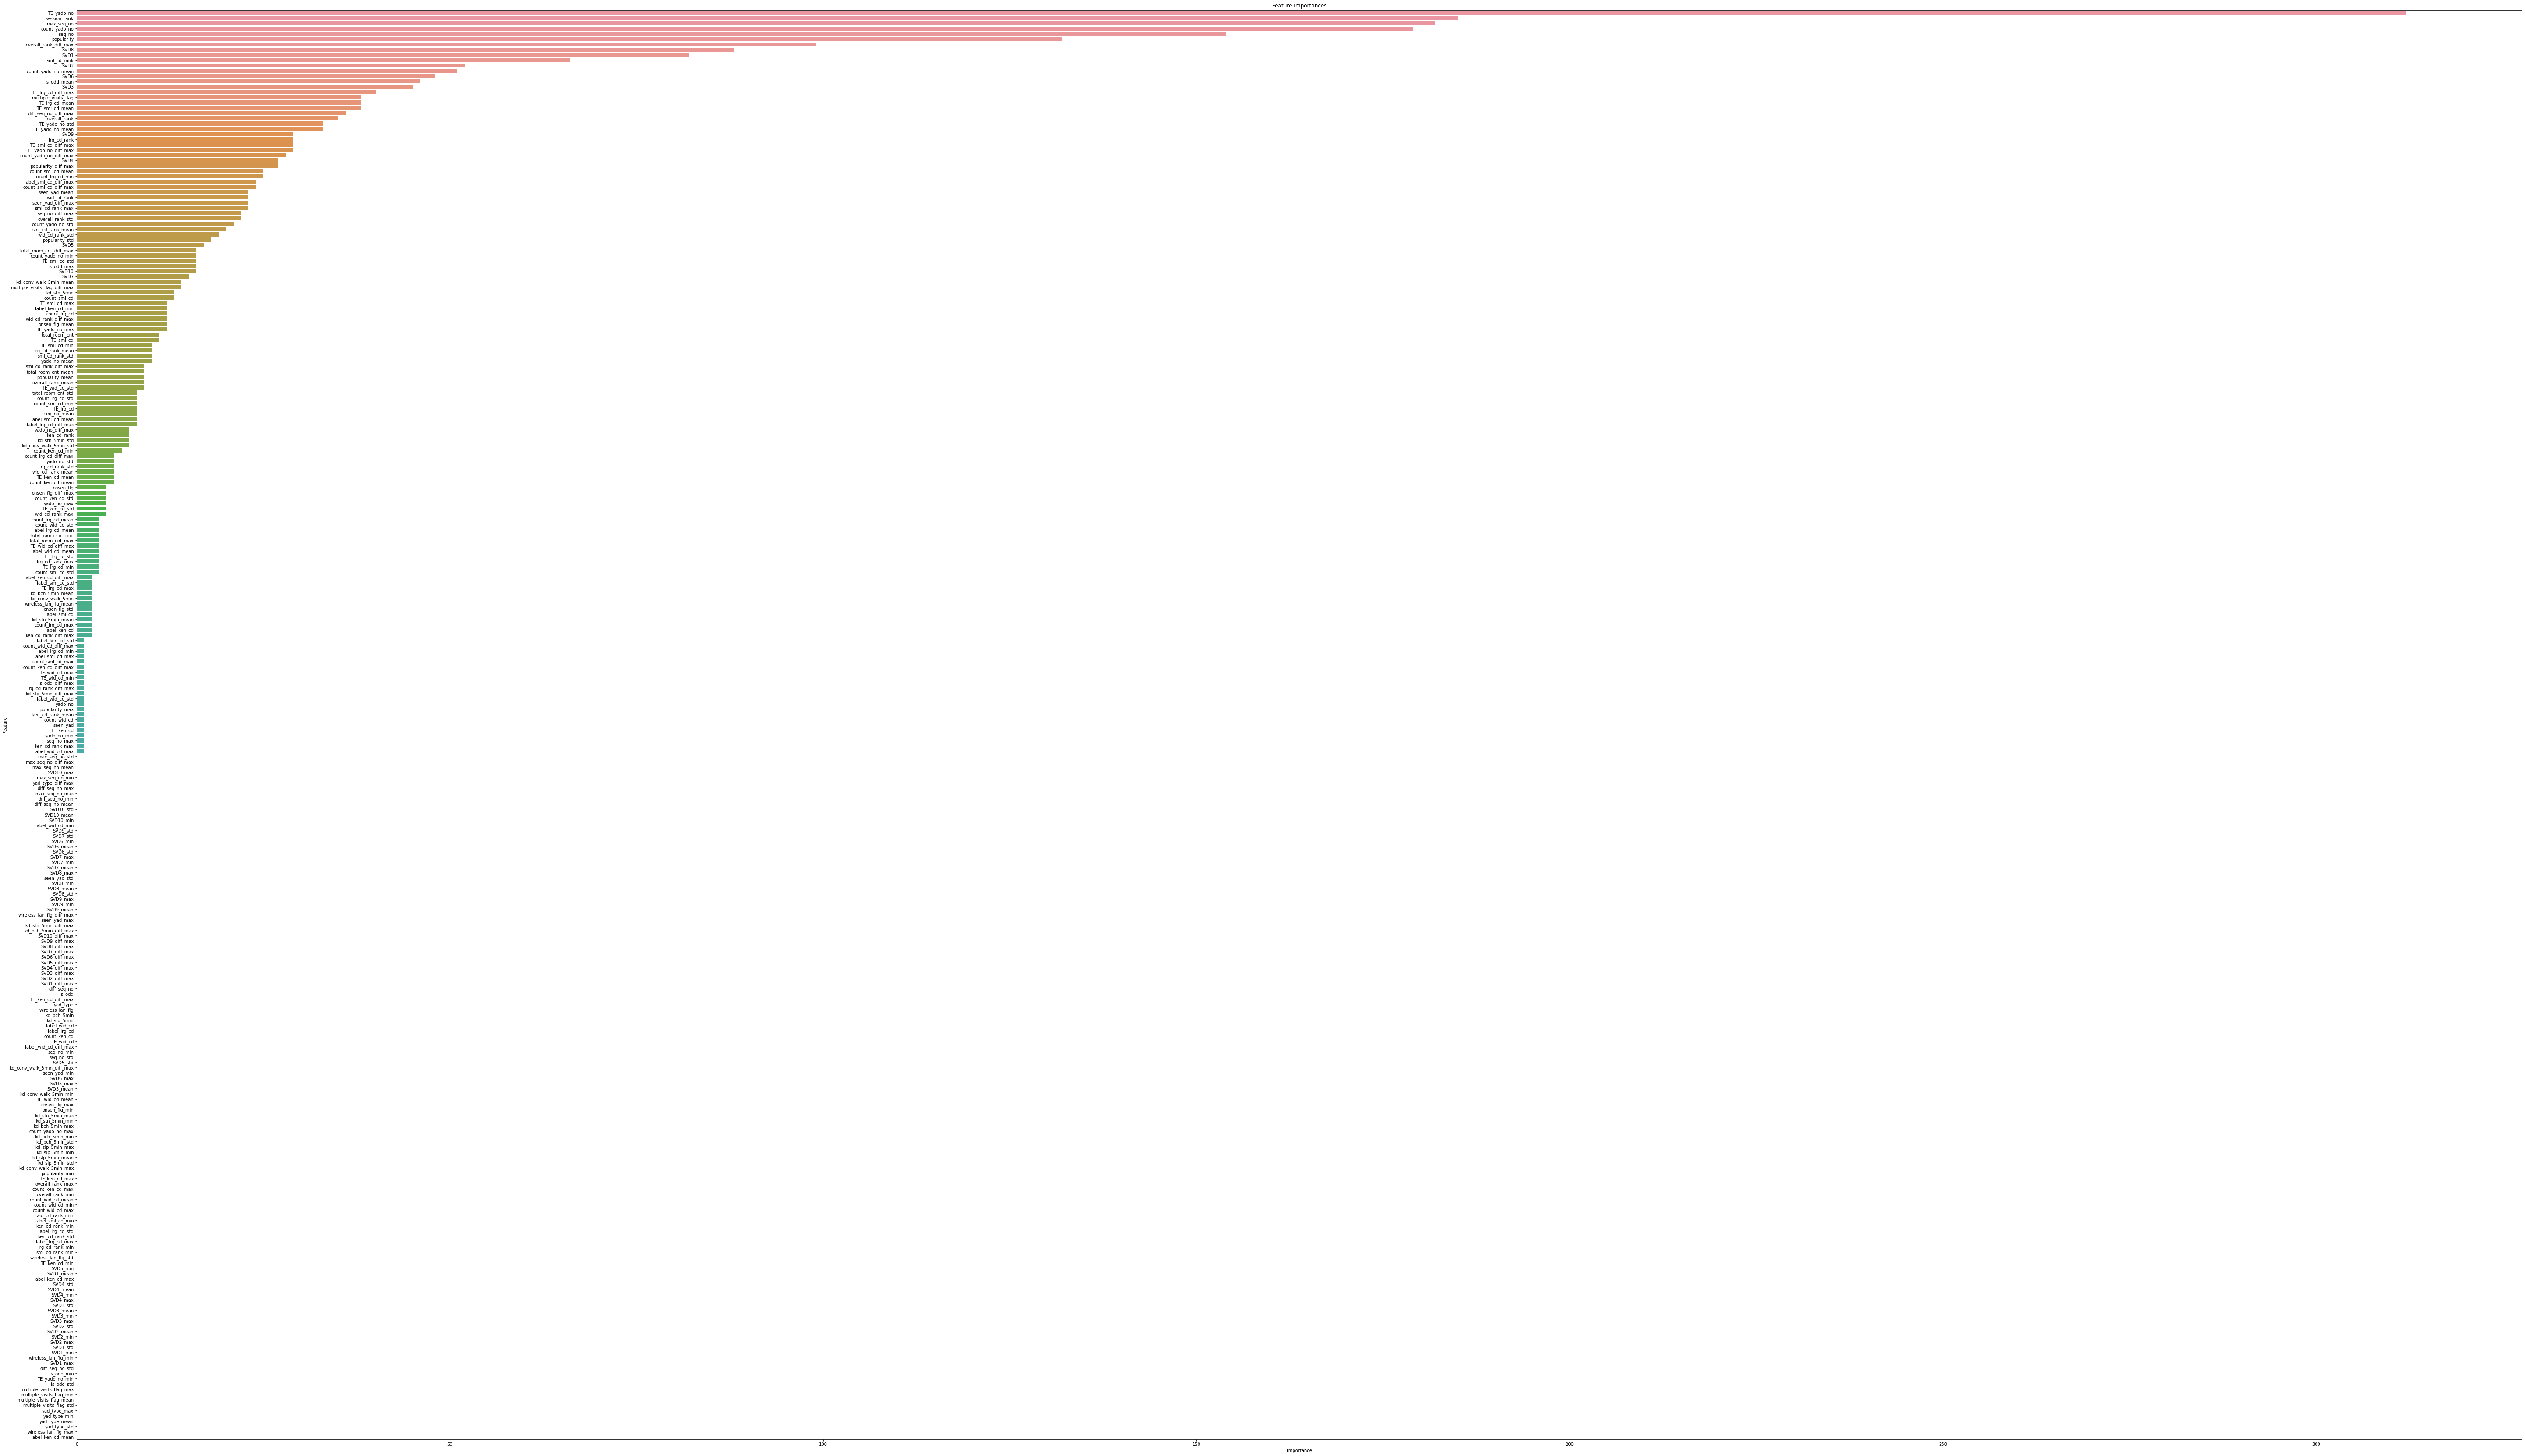

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 特徴量重要度の取得
feature_importances = model.feature_importances_

# 特徴量名とその重要度を DataFrame に変換
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': feature_importances
})

# 重要度で降順にソート
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# 特徴量重要度のプロット
plt.figure(figsize=(100, 60))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [12]:
train_df['oof_pred'] = oof_pred
train_df[['session_id', 'yado_no', 'oof_pred']].head()

,session_id,yado_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,96,0.710903
1,000104bdffaaad1a1e0a9ebacf585f33,902,0.009130
2,000104bdffaaad1a1e0a9ebacf585f33,12491,0.013205
3,000104bdffaaad1a1e0a9ebacf585f33,5490,0.008498
4,000104bdffaaad1a1e0a9ebacf585f33,1284,0.008498


In [13]:
# Use 'session_id' from train_label to order train_df
train_df_ordered = train_df.set_index('session_id').loc[train_label['session_id']].reset_index()[['session_id', 'yado_no', 'oof_pred']]
train_df_ordered.head()

,session_id,yado_no,oof_pred
0,000007603d533d30453cc45d0f3d119f,11882,0.012599
1,000007603d533d30453cc45d0f3d119f,2808,0.037236
2,000007603d533d30453cc45d0f3d119f,4101,0.011985
3,000007603d533d30453cc45d0f3d119f,5289,0.010631
4,000007603d533d30453cc45d0f3d119f,9187,0.000037


In [14]:
train_df_ordered.head()

,session_id,yado_no,oof_pred
0,000007603d533d30453cc45d0f3d119f,11882,0.012599
1,000007603d533d30453cc45d0f3d119f,2808,0.037236
2,000007603d533d30453cc45d0f3d119f,4101,0.011985
3,000007603d533d30453cc45d0f3d119f,5289,0.010631
4,000007603d533d30453cc45d0f3d119f,9187,0.000037


In [15]:
# train_df_ordered を 'session_id' と 'oof_pred' でソート
sorted_df = train_df_ordered.sort_values(by=['session_id', 'oof_pred'], ascending=[True, False])

# 各 session_id ごとに上位10件を取得
top10_df = sorted_df.groupby('session_id').head(10)

# 新しい列 'rank' を追加して各 session_id 内での順位を表す
top10_df['rank'] = top10_df.groupby('session_id').cumcount()

# 'rank' 列と 'session_id' 列を使って pivot する
result_df = top10_df.pivot(index='session_id', columns='rank', values='yado_no')
result_df.columns = [f'predict_{i}' for i in range(10)]  # 列名を設定
result_df = result_df.reset_index()

result_df.head()



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,session_id,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,000007603d533d30453cc45d0f3d119f,11101,7157,11134,997,5821,8927,12846,4391,1648,12837
1,0000ca043ed437a1472c9d1d154eb49b,2570,8253,8140,13717,3184,825,1092,13682,3564,8677
2,0000d4835cf113316fe447e2f80ba1c8,9039,918,13642,2957,6722,9854,6676,7796,7509,11031
3,0000fcda1ae1b2f431e55a7075d1f500,1341,10483,11715,755,8355,9790,9438,6178,7812,1924
4,000104bdffaaad1a1e0a9ebacf585f33,96,3894,7749,12491,10915,902,11380,12338,5490,1284


In [20]:
# result_df.to_csv('../data/lgbBinary_ver3_result_df.csv', index=False)

In [35]:
result_df.head(50)

,session_id,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,000007603d533d30453cc45d0f3d119f,11101,7157,11134,997,5821,8927,12846,4391,1648,12837
1,0000ca043ed437a1472c9d1d154eb49b,2570,8253,8140,13717,3184,825,1092,13682,3564,8677
2,0000d4835cf113316fe447e2f80ba1c8,9039,918,13642,2957,6722,9854,6676,7796,7509,11031
3,0000fcda1ae1b2f431e55a7075d1f500,1341,10483,11715,755,8355,9790,9438,6178,7812,1924
4,000104bdffaaad1a1e0a9ebacf585f33,96,3894,7749,12491,10915,902,11380,12338,5490,1284
5,00011afe25c343301ee961b3b0ce2e4d,9981,8169,7407,1418,12305,6170,12598,5076,3271,1502
6,000125c737df1802b6e365f93c96d3c8,2480,441,10442,7531,10378,7273,8929,12226,957,2282
7,0001763050a10b21062a1304fb743fd4,12946,4744,12962,11499,13701,9508,12954,7681,12464,5445
8,000178c4d4d567d4715331dd0cdab76c,1227,4014,5331,6874,3802,13220,2232,12432,2164,4962
9,0001e6a407a85dc50ac132a5c7016bab,3483,379,10478,4303,8384,9430,1585,4872,550,12724


In [36]:
train_log.head(60)

,session_id,seq_no,yad_no
0,000007603d533d30453cc45d0f3d119f,0,2395
1,0000ca043ed437a1472c9d1d154eb49b,0,13535
2,0000d4835cf113316fe447e2f80ba1c8,0,123
3,0000fcda1ae1b2f431e55a7075d1f500,0,8475
4,000104bdffaaad1a1e0a9ebacf585f33,0,96
5,000104bdffaaad1a1e0a9ebacf585f33,1,898
6,00011afe25c343301ee961b3b0ce2e4d,0,6868
7,000125c737df1802b6e365f93c96d3c8,0,8602
8,0001763050a10b21062a1304fb743fd4,0,13106
9,000178c4d4d567d4715331dd0cdab76c,0,12062


In [17]:
y_true = train_label['yad_no'].values.reshape(-1, 1)
y_pred = result_df.drop(columns=['session_id']).values

In [18]:
y_true

array([[ 4101],
       [ 8253],
       [ 4863],
       ...,
       [13719],
       [10619],
       [ 2439]])

In [19]:
y_pred

array([[11101,  7157, 11134, ...,  4391,  1648, 12837],
       [ 2570,  8253,  8140, ..., 13682,  3564,  8677],
       [ 9039,   918, 13642, ...,  7796,  7509, 11031],
       ...,
       [12240,  4398,  2087, ...,  7308,  3650,  3699],
       [10619,   570, 12500, ..., 11091,  6933,  6595],
       [ 2439, 10415, 10439, ..., 12350, 10095,  3848]], dtype=int16)

In [20]:
# Recall(候補にあげたものが)のy_trueに含まれているものの割合

# マッチするかどうかをチェックするリストを初期化
matches = []

# y_pred の各サブアレイと y_true の値を比較
for pred, true in zip(y_pred, y_true):
    # pred はサブアレイ、true は値
    matches.append(int(true in pred))

# matches は、指定された条件に基づいて 0 と 1 のリストです
print(matches)

# matches は先のステップで生成した 0 と 1 のリストです。
# 1 の割合を計算
one_ratio = sum(matches) / len(matches)

# 割合をプリント
print("Recall is: {:.2%}".format(one_ratio))

[0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 

In [21]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the AP at k between two lists of items.
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean AP at k between two lists of list of items.
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

# y_true と y_pred をリストに変換
y_true_list = [list(x) for x in y_true]
y_pred_list = [list(x) for x in y_pred]

# MAP@10 を計算
map_at_10 = mapk(y_true_list, y_pred_list, k=10)
print(f'Map@10  {map_at_10}')


Map@10  0.38282590188439897


### 予測ファイルの作成

In [ ]:
#　testデータに結合
#　session_idとyado_noとtargetを結合
#  session_idごとにtargetの上位10件のyado_noを抽出を抽出し、画像のような横10列のデータセットに整形してください

In [22]:
print(np.mean(test_pred, axis=0))  # 各foldのテストデータの予測値の平均をとる
print(len(np.mean(test_pred, axis=0)))

[0.86904125 0.00369672 0.00610695 ... 0.01287261 0.01806622 0.00758731]
8735000


In [23]:
test_df['target'] = np.mean(test_pred, axis=0)
test_df[['session_id', 'yado_no', 'target']].head()

,session_id,yado_no,target
0,00001149e9c73985425197104712478c,3560,0.869041
1,00001149e9c73985425197104712478c,4545,0.003697
2,00001149e9c73985425197104712478c,9534,0.006107
3,00001149e9c73985425197104712478c,6563,0.005071
4,00001149e9c73985425197104712478c,4420,0.005983


In [24]:
test_session

,session_id
0,00001149e9c73985425197104712478c
1,0000e02747d749a52b7736dfa751e258
2,0000f17ae2628237d78d3a38b009d3be
3,000174a6f7a569b84c5575760d2e9664
4,00017e2a527901c9c41b1acef525d016
...,...
174695,fffee3199ef94b92283239cd5e3534fa
174696,ffff62c6bb49bc9c0fbcf08494a4869c
174697,ffff9a7dcc892875c7a8b821fa436228
174698,ffffb1d30300fe17f661941fd085b04b


In [25]:
# Use 'session_id' from test_session to order test_df
test_df_ordered = test_df.set_index('session_id').loc[test_session['session_id']].reset_index()[['session_id', 'yado_no', 'target']]
test_df_ordered.head()

,session_id,yado_no,target
0,00001149e9c73985425197104712478c,3560,0.869041
1,00001149e9c73985425197104712478c,4545,0.003697
2,00001149e9c73985425197104712478c,9534,0.006107
3,00001149e9c73985425197104712478c,6563,0.005071
4,00001149e9c73985425197104712478c,4420,0.005983


In [26]:
test_df_ordered.sort_values(by=['session_id', 'target'], ascending=[True, False])

,session_id,yado_no,target
0,00001149e9c73985425197104712478c,3560,0.869041
21,00001149e9c73985425197104712478c,9830,0.027765
27,00001149e9c73985425197104712478c,6766,0.024050
10,00001149e9c73985425197104712478c,2680,0.022599
25,00001149e9c73985425197104712478c,2040,0.020461
...,...,...,...
8734990,ffffe984aafd6127ce8e43e3ca40c79d,5508,0.002936
8734966,ffffe984aafd6127ce8e43e3ca40c79d,9168,0.001225
8734969,ffffe984aafd6127ce8e43e3ca40c79d,9183,0.000050
8734968,ffffe984aafd6127ce8e43e3ca40c79d,9182,0.000050


In [27]:
# test_df_ordered を 'session_id' と 'oof_pred' でソート
sorted_df = test_df_ordered.sort_values(by=['session_id', 'target'], ascending=[True, False])

# 各 session_id ごとに上位10件を取得
top10_df = sorted_df.groupby('session_id').head(10)

# 新しい列 'rank' を追加して各 session_id 内での順位を表す
top10_df['rank'] = top10_df.groupby('session_id').cumcount()

# 'rank' 列と 'session_id' 列を使って pivot する
submit_df = top10_df.pivot(index='session_id', columns='rank', values='yado_no')
submit_df.columns = [f'predict_{i}' for i in range(10)]  # 列名を設定
submit_df = submit_df.reset_index()

submit_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,session_id,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,00001149e9c73985425197104712478c,3560,9830,6766,2680,2040,5466,11496,11561,4948,10965
1,0000e02747d749a52b7736dfa751e258,4066,6555,12862,11237,143,7014,5055,11923,8821,8044
2,0000f17ae2628237d78d3a38b009d3be,757,9910,410,2267,11001,6730,6721,7710,10485,10104
3,000174a6f7a569b84c5575760d2e9664,12341,2795,277,6991,5657,3359,10861,11798,10535,7413
4,00017e2a527901c9c41b1acef525d016,12029,5713,9623,3844,12524,6576,13590,6161,5372,3187


In [28]:
# 欠損がないかをチェック
print(submit_df.isnull().sum(axis=1).sum())
print(submit_df.shape)

0
(174700, 11)


In [34]:
# submit_df.to_csv('../data/lgbBinary_ver3_submit_df.csv', index=False)

In [29]:
submit_df.drop(columns=['session_id']).to_csv('../submissions/lgbBinary_ver5.csv', index=False)